# Welcome to my notebook!

## What is this notebook about?

Welcome to Nigar's first preliminary analysis notebook! Ok, let's switch back to first person. 

In this notebook, I will be working on an image analysis pipeline for the images that I obtain using HoloMonitor microscope, which I use to image the cells that I grow in the lab. 

The goal of this notebook is to: 
- load images 
- smooth out cells using a Gaussian filter with a mean equal to ca a size of a single cell 
- more or less cleanup the images so that we only have cells visible 
- obtain a velocity map of the cells 

## Code and data 

Let's import all of the necessary libraries and load in our images. This might take a while depending on the size and number of images, so we keep the import of images-stage in one cell. 

In [2]:
import os
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerics
from skimage import io
from natsort import natsorted
#import skimage.io
import skimage.color
import skimage.morphology
import skimage.measure as sm

from skimage.io import imread
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from skimage import (io, filters,  morphology, measure, segmentation, feature, util, exposure)
from scipy.ndimage import gaussian_filter 
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom

In [3]:
# Load multiple images. Example taken from https://scikit-image.org/docs/dev/user_guide/getting_started.html

plt.rcParams['figure.figsize'] = [10,10]

folder_path = './Images/MDCK-pos1/'
list_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
list_files = natsorted(list_files)
image_list = []
# Filename fc2_save_2023-03-22-182010-0NNN.tif
for filename in list_files:
    image_list.append(io.imread(filename))

Now, let's visualise some of these images!

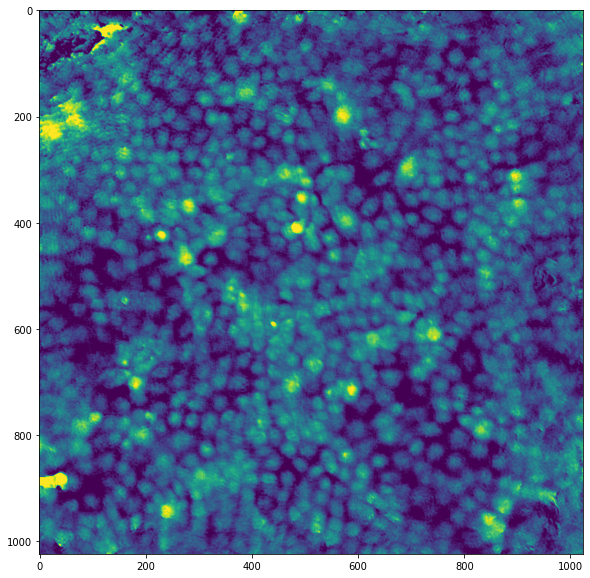

In [4]:
plt.imshow(image_list[0]) #plotting the very first image here to see what it looks like

I am quite unhappy with the top left corner, so I would like to crop the image and only focus on the middle of the image. This would mean ca 300-800 pixels on y-axis and 200-700 pixels on x-axis.

500


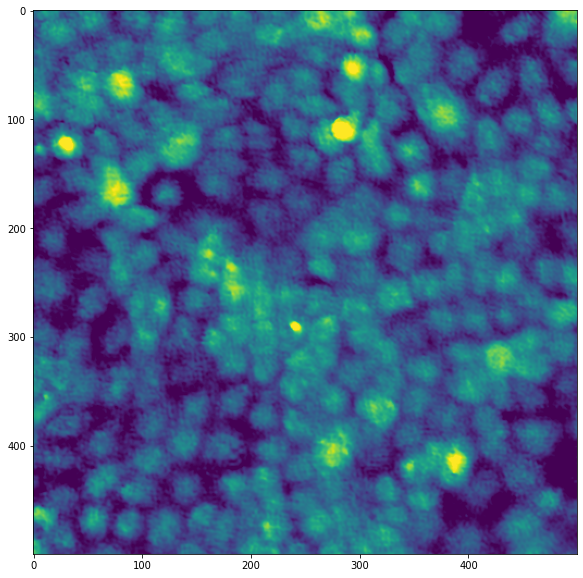

In [5]:
cropped_image = image_list[0][300:800, 200:700]
plt.imshow(cropped_image)
print(len(cropped_image[:]))

Much nicer! Now, let's try to smooth out the image. I will use a Gaussian filter with a mean equal to ca a size of a single cell. I will use a mean of 10 pixels.

(500, 500)


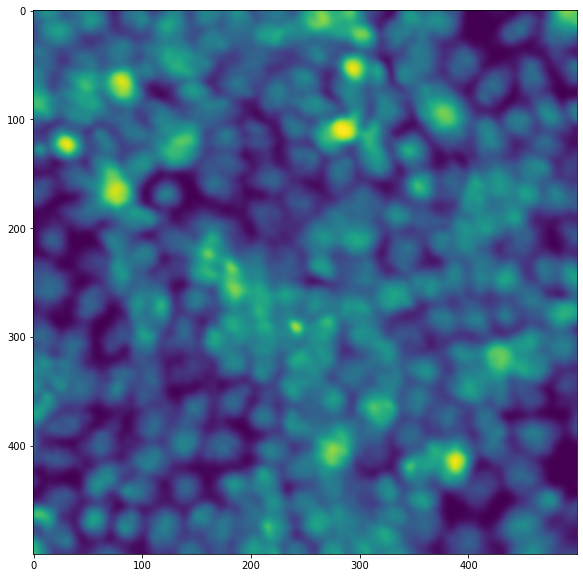

In [6]:
img = cropped_image

print(img.shape)

img_gau = filters.gaussian(img, sigma = 3)
plt.imshow(img_gau)

In [40]:
#print out intensity values of the image before and after filtering - but are these really intensities...? Need to figure out!

print('Before filtering: ', cropped_image[0])
print('After filtering: ', img_gau[0])

Before filtering:  [118 110 100  90  90  98 106 118 138 152 154 152 148 142 136 134 136 136
 132 132 138 136 126 114 104  96  90  92 100 106 104 100  98 100 104 106
 102  98 102 112 118 116 120 122 120 114 116 128 138 140 142 140 132 124
 122 120 114 104  96  94  96  96  96  96  92  88  84  78  66  58  52  43
  29  19  23  39  50  48  46  50  54  54  58  74  90  96  96  98 102 104
 104 102 102 104 110 118 128 128 120 112 104  94  88  84  80  68  54  52
  62  68  62  54  54  60  70  78  82  74  72  80  92 100 110 122 130 134
 134 126 114 108 114 128 132 124 116 112 106  92  82  80  82  80  72  68
  70  76  86  94  98  94  92  98 106 114 122 130 132 132 132 134 132 126
 120 120 122 126 130 130 122 112 108 110 110 102  94 100 108 104  96  96
 110 122 126 132 140 140 136 136 144 146 134 122 122 124 118 106  98  90
  78  70  70  74  68  58  62  80  94  92  90 100 110 110 100  96  96  94
  84  76  90 104 108 110 114 116 112 110 108 108 110 110 108 104 104 104
 102  94  82  74  68  62  60  66

### So, future Nigar, here are some things to do:
- figure out the deal with intensity values
- maybe do some other type of filtering: lowpass?
- check the time step between each image was taken: might be useful for velocity field plotting 
- get started on the velocity field plotting

### Future Nigar here!
Time to do some cool analysis. The end goal is to obtain a velocity field of the cells. To do so, I firstly need to track the cells and obtain their displacement fields. One of the methods to do it is to use the optical flow method. The other one is to use TrackPy to track the cells. I will try both of these methods and see which one works better.

Before doing that, however, I need to do some more image processing. I need to clean up the images a bit more and remove the background. I will do this by using a lowpass filter. Let's see how it goes!

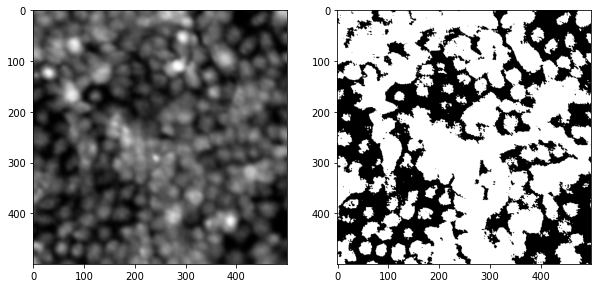

In [69]:
#use boolean operators to create a mask: only want to keep cells that are brighter than the background
# mask = img_gau > 0.3
mask = cropped_image > 70

#plot mask and img_gau as subplots to compare 
fig, axes = plt.subplots(1,2)
ax = axes.ravel()
ax[0].imshow(img_gau, cmap=plt.cm.gray)
# ax[0].set_title('Original image')
ax[1].imshow(mask, cmap=plt.cm.gray)
# ax[1].set_title('Mask')


Okay, this was not exactly the lowpass filter - here, I was just trying to threshold the image. But, now that I think about it, it might not be necessary. Given that the contrast in our images is good enough, we can try using TrackPy directly to track the cells. Let's see how that goes!

In [72]:
#import trackpy first!
import trackpy as tp

Now, let's make a series of cropped images from our original images. We will use these images to track the cells using TrackPy. We will use a size of 500x500 pixels for each image.

In [111]:
cropped_images = []
for i in range(len(image_list)):
    cropped_images.append(image_list[i][300:500, 200:400]) #changed from 300:800, 200:700 to 300:500, 200:400
print("Number of images in a stack:", len(cropped_images))

Number of images in a stack: 301


Visualise some of the cropped images just to make sure that everything is fine:

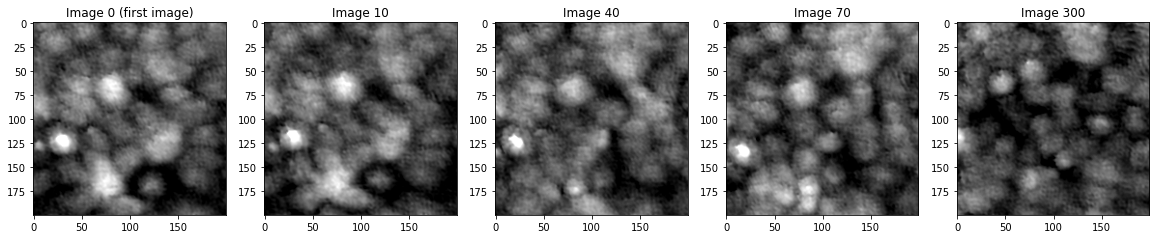

In [112]:
# Create subplots with 1 row and 5 columns
image_size = (20,20)
fig, axes = plt.subplots(1, 5, figsize=image_size)
ax = axes.ravel()

# Display images and set titles
ax[0].imshow(cropped_images[0], cmap=plt.cm.gray)
ax[0].set_title('Image 0 (first image)')
ax[1].imshow(cropped_images[9], cmap=plt.cm.gray)
ax[1].set_title('Image 10')
ax[2].imshow(cropped_images[39], cmap=plt.cm.gray)
ax[2].set_title('Image 40')
ax[3].imshow(cropped_images[69], cmap=plt.cm.gray)
ax[3].set_title('Image 70')
ax[4].imshow(cropped_images[299], cmap=plt.cm.gray)
ax[4].set_title('Image 300')

# Show the subplots
plt.show()


A part of me wants to blur these images and see if TrackPy will do better on blurred images... Let's see!

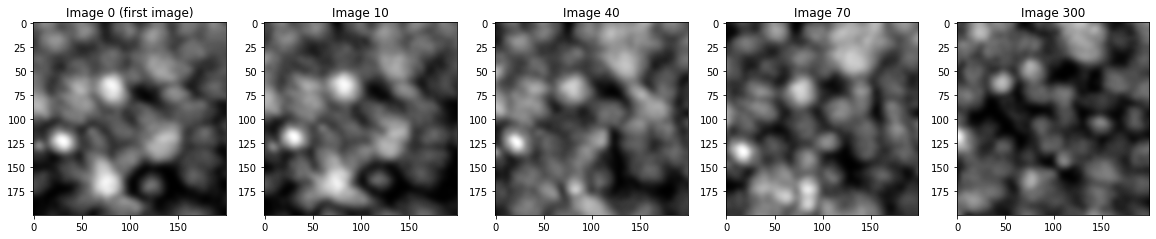

In [142]:
cropped_images_blurred = []
for i in range(len(cropped_images)):
    cropped_images_blurred.append(filters.gaussian(cropped_images[i], sigma = 3)) #used to be sigma = 1.7
    
image_size = (20,20)
fig, axes = plt.subplots(1, 5, figsize=image_size)
ax = axes.ravel()

# Display images and set titles
ax[0].imshow(cropped_images_blurred[0], cmap=plt.cm.gray)
ax[0].set_title('Image 0 (first image)')
ax[1].imshow(cropped_images_blurred[9], cmap=plt.cm.gray)
ax[1].set_title('Image 10')
ax[2].imshow(cropped_images_blurred[39], cmap=plt.cm.gray)
ax[2].set_title('Image 40')
ax[3].imshow(cropped_images_blurred[69], cmap=plt.cm.gray)
ax[3].set_title('Image 70')
ax[4].imshow(cropped_images_blurred[299], cmap=plt.cm.gray)
ax[4].set_title('Image 300')

# Show the subplots
plt.show()

So much better! I think that TrackPy will appreacite this as well. Off we go, yalla!

In [143]:
print(max(cropped_images_blurred[0][0]))

0.5504856873551225


In [150]:
# Locate features (cells) in the first frame just to see what it looks like and adjust parameters if need be!
feature_radius = 17  # Adjust this parameter based on the size of your cells
min_mass = 0.5     # Adjust this parameter based on the brightness of your cells
batch = [cropped_images_blurred[0]]
frames = tp.batch(batch, feature_radius, minmass=min_mass)


Frame 0: 36 features


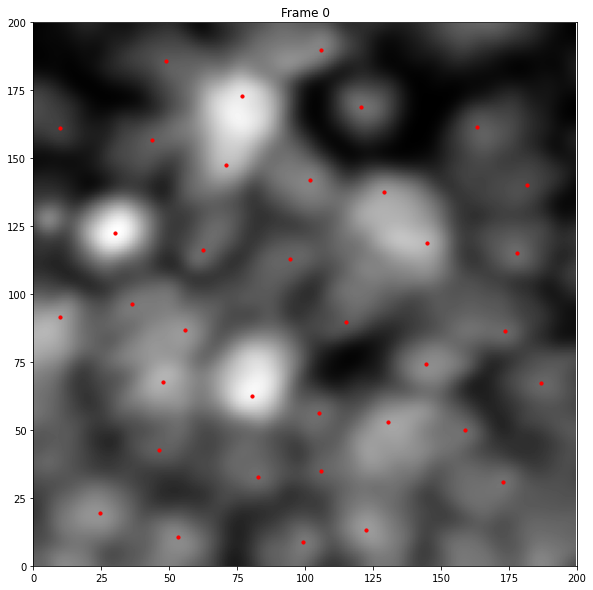

In [151]:
# Assuming you have already detected features and stored them in the 'frames' DataFrame
# 'frame_number' should be the index of the specific frame you want to analyze

# Select the features detected in the desired frame
desired_frame_number = 0  # Change this to the frame you want to analyze
features_in_frame = frames[frames['frame'] == desired_frame_number]

# Load the corresponding frame from 'cropped_images' (assuming it's a list of frames)
desired_frame = cropped_images_blurred[desired_frame_number]

# Plot the original frame
plt.figure()
plt.imshow(desired_frame, cmap='gray')  # Assuming grayscale images

# Overlay the detected features on the frame
plt.scatter(features_in_frame['x'], features_in_frame['y'], c='red', s=10)  # Adjust color and size as needed

# Set axis limits to match the frame size
plt.xlim(0, desired_frame.shape[1])
plt.ylim(0, desired_frame.shape[0])

# Add a title with the frame number
plt.title(f"Frame {desired_frame_number}")

# Display or save the frame with detected features
plt.show()

Honestly, looking pretty good! Let's see how the blurred image compares to the non-blurred one in terms of tracking. 

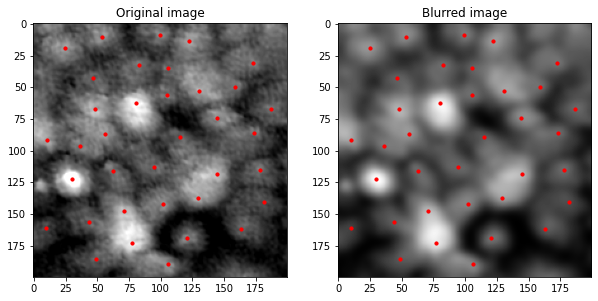

In [157]:
# Assuming you have already detected features and stored them in the 'frames' DataFrame
# 'frame_number' should be the index of the specific frame you want to analyze

# Select the features detected in the desired frame
desired_frame_number = 0  # Change this to the frame you want to analyze
features_in_frame = frames[frames['frame'] == desired_frame_number]

# Load the corresponding frame from 'cropped_images' (assuming it's a list of frames)
desired_frame_noblur = cropped_images[desired_frame_number]
desired_frame = cropped_images_blurred[desired_frame_number]

#plot the original frame and the blurred frame as a subplot to compare
fig, axes = plt.subplots(1,2)
ax = axes.ravel()
ax[0].imshow(desired_frame_noblur, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(desired_frame, cmap=plt.cm.gray)
ax[1].set_title('Blurred image')

#overlay the detected features on the original and blurred frames
ax[0].scatter(features_in_frame['x'], features_in_frame['y'], c='red', s=10)
ax[1].scatter(features_in_frame['x'], features_in_frame['y'], c='red', s=10)


Looks great! TrackPy is more or less recognising the correct cells. Let's see if we can get the trajectories of the cells. Firstly, we need to do this tracking procedure for all of our frames.

In [158]:
feature_radius = 17  # Adjust this parameter based on the size of your cells
min_mass = 0.5     # Adjust this parameter based on the brightness of your cells
frames = tp.batch(cropped_images_blurred, feature_radius, minmass=min_mass)

Frame 300: 34 features
